#Code - 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplt
import math as m
from tqdm import tqdm
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

zero_color = "#cfcc23"
one_color = "#208724"
two_color = "#c92f24"
grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.5}
colors = [zero_color, one_color, two_color]
c_map = matplt.colors.LinearSegmentedColormap.from_list("", colors)

In [2]:
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
# function to render frames for animations
from tqdm import tqdm
from matplotlib import rc
rc('animation', html='jshtml')

fps = 8.0
dt = 1
grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.2}

def render_frame(i, data):
    ax.cla()

    grid = data[i].tolist()
    # print(data)
    rows = len(grid)
    cols = len(grid[0])
    labels = []
    for r in range(rows):
      temp = []
      for c in range(cols):
        temp.append(grid[r][c])
      labels.append(temp)
    #cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    sns.heatmap(data[i],
                ax = ax,
                cbar = True,
                cbar_ax = cbar_ax,
                vmin = 0,
                vmax = 2,
                xticklabels=False,
                yticklabels = False,
                cmap='viridis',
                cbar_kws={'label': 'State'})

In [3]:
EMPTY = 0
TREE = 1
BURNING = 2

In [4]:
def initForest(n,probTree, probBurning):
  grid=np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if np.random.uniform(0,1)<probTree:
        if np.random.uniform(0,1)<probBurning:
          grid[i][j]=BURNING
        else:
          grid[i][j]=TREE
      else:
        grid[i][j]=EMPTY
  
  return grid

In [5]:
def periodic_boundary(grid):
  g1=np.concatenate((grid[-1,:].reshape(1,-1),grid),axis=0)
  g1=np.concatenate((g1,g1[1,:].reshape(1,-1)),axis=0)
  g1=np.concatenate((g1[:,-1].reshape(-1,1),g1),axis=1)
  g1=np.concatenate((g1,g1[:,1].reshape(-1,1)),axis=1)
  return g1

In [6]:
def absorbing_boundary(grid):
  g1=np.concatenate((np.ones((1,grid.shape[1])),grid),axis=0)
  g1=np.concatenate((g1,np.ones((1,g1.shape[1]))),axis=0)
  n=g1.shape[0]
  #print(n)
  g1=np.concatenate((np.ones((n,1)),g1),axis=1)
  g1=np.concatenate((g1,np.ones((n,1))),axis=1)
  return g1

In [7]:
# def periodic_lat(lat):
#     lat_NS = np.row_stack((lat[-1], lat, lat[0]))
#     return np.column_stack((lat_NS[:,-1], lat_NS, lat_NS[:,0]))   

In [8]:
def spread(site,N,E,S,W,probImmune,probLightning):
  if site==EMPTY or site==BURNING:
    return EMPTY
  else:
    if (N==BURNING or S==BURNING or E==BURNING or W==BURNING):
      if np.random.uniform(0,1)<probImmune:
        return TREE
      else:
        return BURNING
    else:
      if np.random.uniform(0,1)<(probLightning)*(1-probImmune):
        return BURNING
      else:
        return TREE  

In [9]:
def applyExtended(grid,probImmune,probLightning):
  n = grid.shape[0] - 2
  new_grid = np.zeros((n,n))
  for i in range(1, n+1):
    for j in range(1, n+1):
        site = grid[i][j]
        N = grid[i-1][j]
        E = grid[i][j+1]
        S = grid[i+1][j]
        W = grid[i][j-1]
        new_grid[i-1][j-1] = spread(site, N, E, S, W, probImmune,probLightning)

  return new_grid

In [10]:
def fire(n, probTree, probBurning, probLightning, probImmune, t):
  forest=initForest(n, probTree, probBurning)
  grids=np.zeros((t+1,n,n))
  grids[0,:,:]=forest
  for i in range(1,t+1):
    #forestExtended=periodic_boundary(forest)
    forestExtended=absorbing_boundary(forest)
    forest=applyExtended(forestExtended, probImmune,probLightning)
    grids[i,:,:]=forest
  
  return grids

### Periodic Boundary Conditions

In [11]:
color_map = {0: np.array([255, 255, 0]), # yellow
             1: np.array([0, 180, 0]), # green
             2: np.array([255, 0, 0])} # orange 

def colour_forest(data):
    data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 3), dtype=int)
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            data_3d[i][j] = color_map[data[i][j]]
    return data_3d

In [12]:
def generate_animation(grids, filename):
    t = grids.shape[0]
    fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize=(10, 8))

    def render_frame(i):
        g = sns.heatmap(grids[i],
            ax = ax,
            cbar_ax = cbar_ax,
            cbar = True,
            # annot = labels,
            vmin = 0,
            vmax = 2,
            cbar_kws={'label': 'State'},
            cmap=c_map)
        ax.set_title('t = ' + str(i))
        # g.cax.set_visible(False)

    anim = FuncAnimation(fig = fig, func = render_frame, frames=tqdm(np.arange(len(grids)), initial=1), interval = 1000.0/5, blit = False, repeat = False)

    anim.save(filename, writer = 'ffmpeg', fps = 5)

  1%|          | 1/91 [00:01<?, ?it/s]


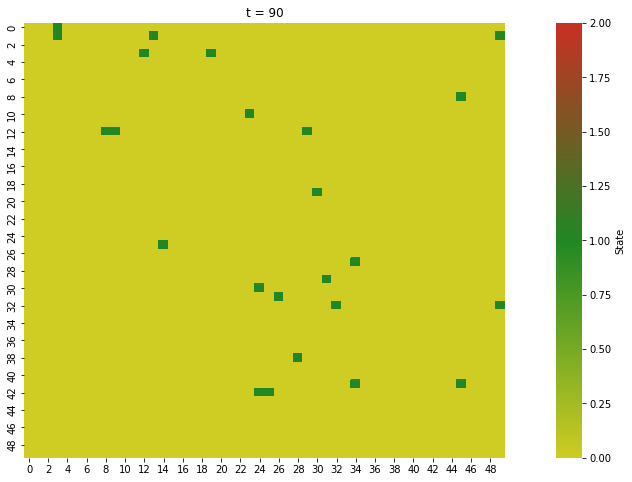

In [13]:
n = 50
probTree = 0.9
probBurning = 0.0005
probImmune = 0.1
probLightning = 0.00001
t=90
grid_list = fire(n, probTree, probBurning, probLightning, probImmune, t)
generate_animation(grid_list,'tree_den90.mp4')


  1%|          | 1/101 [00:00<?, ?it/s]


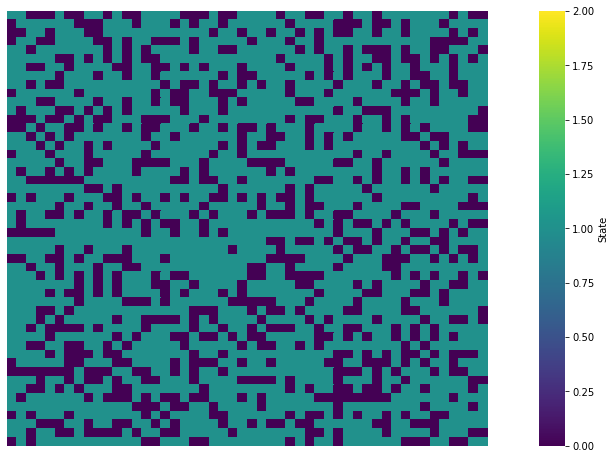

In [ ]:
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize=(10, 8))
ax.set_facecolor('grey')
ax.set_title('Simulation for periodic boundary condition')

# render and play animation
anim = FuncAnimation(fig = fig, func = render_frame, frames=tqdm(range(len(grid_list)), initial=1, position=0), fargs=(grid_list,), interval = 1000.0/fps, blit = False, repeat = False)
anim

### Absorbing Boundary Condition

  1%|          | 1/91 [00:00<?, ?it/s]


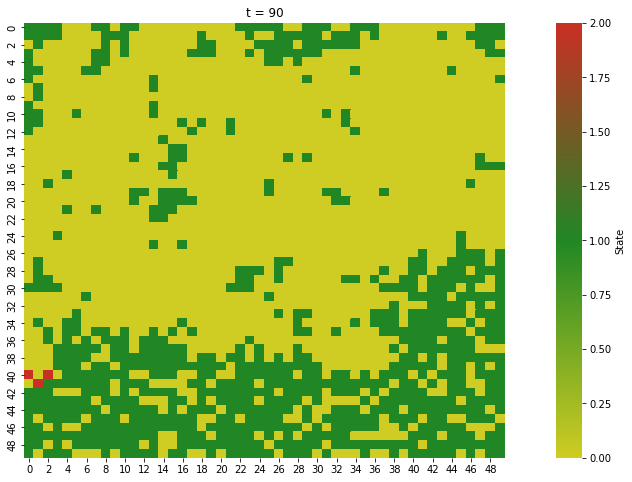

In [ ]:
n = 50
probTree = 0.75
probBurning = 0.0005
probImmune = 0.2
probLightning = 0.00001
t=90
grid_list = fire(n, probTree, probBurning, probLightning, probImmune, t)
generate_animation(grid_list,'absorbing.mp4')

  1%|          | 1/101 [00:00<?, ?it/s]


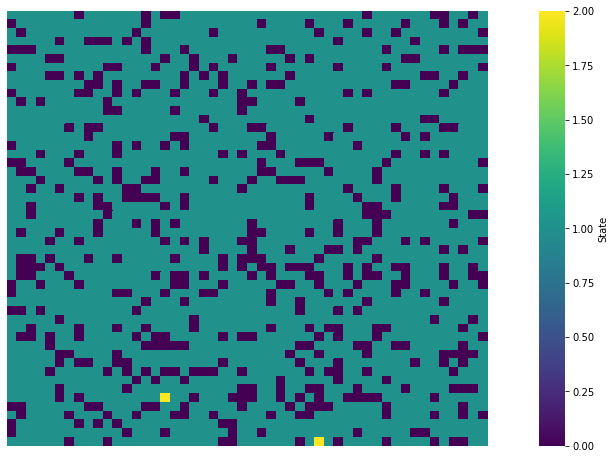

In [ ]:
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize=(10, 8))
ax.set_facecolor('grey')
ax.set_title('Simulation for absorbing boundary condition')

# render and play animation
anim = FuncAnimation(fig = fig, func = render_frame, frames=tqdm(range(len(grid_list)), initial=1, position=0), fargs=(grid_list,), interval = 1000.0/fps, blit = False, repeat = False)
anim

# Project Ques - 9

In [ ]:
def initForest1(n):
  grid=np.ones((n,n))
  grid[n//2,n//2]=2
  return grid

In [ ]:
def spread1(site,N,E,S,W,probBurning):
  if site==EMPTY or site==BURNING:
    return EMPTY
  else:
    if (N==BURNING or S==BURNING or E==BURNING or W==BURNING):
      if np.random.uniform(0,1)<probBurning:
        return BURNING
      else:
        return TREE 
    else:
      return TREE

In [ ]:
def do_simulation(temp,n,prob_burn):
  n=temp.shape[0]-2
  new_grid=np.zeros((n,n))
  for i in range(1,n+1):
    for j in range(1,n+1):
      N=temp[i-1][j]
      S=temp[i+1][j]
      E=temp[i][j+1]
      W=temp[i][j-1]
      new_grid[i-1][j-1]=spread1(temp[i][j],N,E,S,W,prob_burn)
    
  return new_grid

In [ ]:
def simulation(t,iterations,probBurning,n):
  grid=initForest1(n)
  avg_burned=[]
  for prob_burn in probBurning:
    val=[]
    every_step=[]
    for i in range(iterations):
      temp=grid
      for j in range(1,t+1):
        temp=absorbing_boundary(temp)
        temp=do_simulation(temp,n,prob_burn)
        if i==0:
          every_step.append(np.bincount(list(temp.flatten()))[0]/(n*n))
        #print(temp)
      
      #print(temp)
      count_burn=np.bincount(list(temp.flatten()))[0]
      val.append(count_burn/(n*n))
    
    plt.plot(np.arange(0,t,1),every_step,lw=2,label=f'burnProb={prob_burn}')
    
    avg_burned.append(np.mean(val))
  
  plt.xlabel('Time')
  plt.ylabel('Fraction of forest burnt')
  plt.grid()
  plt.legend()
  
  return avg_burned

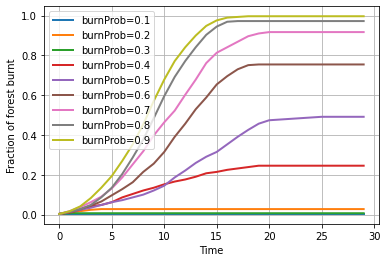

In [ ]:
avg_burned=simulation(30,10,np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),17)

In [ ]:
avg_burned

[0.006228373702422146,
 0.010726643598615918,
 0.016262975778546712,
 0.06920415224913495,
 0.29619377162629756,
 0.6833910034602075,
 0.8892733564013839,
 0.9629757785467128,
 0.9899653979238755]

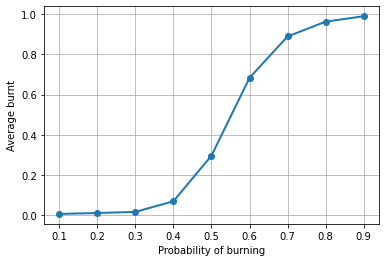

In [ ]:
plt.plot(np.arange(0.1,1,0.1),avg_burned,'o-',lw=2)
plt.xlabel('Probability of burning')
plt.ylabel('Average burnt')
plt.grid()

#Ex - 2

In [ ]:
def initForest1(n):
  grid=np.ones((n,n))
  grid[n//2,n//2]=2
  return grid

In [ ]:
def spread1(site,N,E,S,W,probBurning):
  if site==EMPTY or site==BURNING:
    return EMPTY
  else:
    if (N==BURNING or S==BURNING or E==BURNING or W==BURNING):
      cnt=0
      cnt+=(N==BURNING)
      cnt+=(S==BURNING)
      cnt+=(E==BURNING)
      cnt+=(W==BURNING)
      if np.random.uniform(0,1)<probBurning*cnt:
        return BURNING
      else:
        return TREE 
    else:
      return TREE

In [ ]:
def do_simulation(temp,n,prob_burn):
  n=temp.shape[0]-2
  new_grid=np.zeros((n,n))
  for i in range(1,n+1):
    for j in range(1,n+1):
      N=temp[i-1][j]
      S=temp[i+1][j]
      E=temp[i][j+1]
      W=temp[i][j-1]
      new_grid[i-1][j-1]=spread1(temp[i][j],N,E,S,W,prob_burn)
    
  return new_grid

In [ ]:
def simulation(t,iterations,probBurning,n):
  grid=initForest1(n)
  avg_burned=[]
  for prob_burn in probBurning:
    val=[]
    every_step=[]
    for i in range(iterations):
      temp=grid
      for j in range(1,t+1):
        temp=absorbing_boundary(temp)
        temp=do_simulation(temp,n,prob_burn)
        if i==0:
          every_step.append(np.bincount(list(temp.flatten()))[0]/(n*n))
        #print(temp)
      
      #print(temp)
      count_burn=np.bincount(list(temp.flatten()))[0]
      val.append(count_burn/(n*n))
    
    plt.plot(np.arange(0,t,1),every_step,lw=2,label=f'burnProb={prob_burn}')
    
    avg_burned.append(np.mean(val))
  
  plt.xlabel('Time')
  plt.ylabel('Fraction of forest burnt')
  plt.grid()
  plt.legend()
  
  return avg_burned

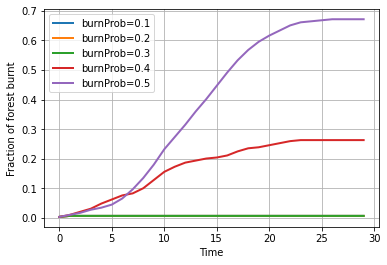

In [ ]:
avg_burned=simulation(30,10,np.array([0.1, 0.2, 0.3, 0.4, 0.5]),17)

In [ ]:
avg_burned

[0.024221453287197235, 0.0809688581314879, 0.7512110726643599]

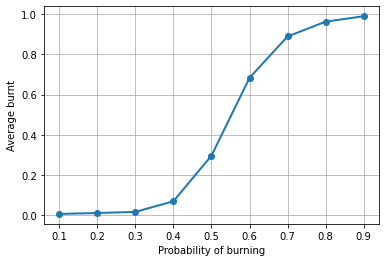

In [ ]:
plt.plot(np.arange(0.1,1,0.1),avg_burned,'o-',lw=2)
plt.xlabel('Probability of burning')
plt.ylabel('Average burnt')
plt.grid()

#Ex - 1

In [ ]:
BURN_FIN = 3

In [ ]:
def spread2(site, N, E, S, W, prob_light, prob_immune):
    if(site == EMPTY or site == BURN_FIN):
        return EMPTY
    elif(site == BURNING):
        return BURN_FIN
    else:
        if(N==BURNING or E==BURNING or S==BURNING or W==BURNING 
           or N==BURN_FIN or E==BURN_FIN or S==BURN_FIN or W==BURN_FIN):
            if(np.random.uniform(0,1) < prob_immune):
                return TREE
            else:
                return BURNING
        else:
            if(np.random.uniform(0,1) < prob_light * (1 - prob_immune)):
                return BURNING
            else:
                return TREE

In [ ]:
def apply_extended2(grid, prob_light, prob_immune):
    n = grid.shape[0] - 2
    new_grid = np.zeros((n,n))
    for i in range(1, n+1):
        for j in range(1, n+1):
            site = grid[i][j]
            N = grid[i-1][j]
            E = grid[i][j+1]
            S = grid[i+1][j]
            W = grid[i][j-1]
            new_grid[i-1][j-1] = spread2(site, N, E, S, W, prob_light, prob_immune)
    return new_grid

In [ ]:
def fire2(n, prob_tree, prob_burning, prob_light, prob_immune, t):
    forest = initForest1(n)
    grids = np.zeros((t+1, n, n))
    grids[0,:,:] = forest
    for i in range(1, t+1):
        forest_ext = periodic_boundary(forest)
        forest = apply_extended2(forest_ext, prob_light, prob_immune)
        grids[i,:,:] = forest
    return grids

In [ ]:
color_map2 = {0: np.array([255, 255, 0]), # yellow
             1: np.array([0, 180, 0]), # green
             2: np.array([255, 0, 0]), # orange
             3: np.array([255, 0, 0]), # orange
             }  
def colour_forest2(data):
    data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 3), dtype=int)
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            data_3d[i][j] = color_map2[data[i][j]]
    return data_3d

In [ ]:
np.random.seed(2)
n = 17
prob_tree = 0.75
prob_burning = 0.001
prob_light = 0
prob_immune = 0
t = 100
grids = fire2(n, prob_tree, prob_burning, prob_light, prob_immune, t)

In [ ]:
def generate_cf2_animation(grids, filename):
    t = grids.shape[0]
    fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize=(8, 8))

    def render_frame(i):
        g = sns.heatmap(colour_forest2(grids[i])[0],
            ax = ax,
            cbar_ax = cbar_ax,
            cbar = False,
            # annot = labels,
            vmin = 0,
            vmax = 2,
            cbar_kws={'label': 'State'},
            cmap=c_map)
        ax.set_title('t = ' + str(i))
        # g.cax.set_visible(False)

    anim = FuncAnimation(fig = fig, func = render_frame, frames=tqdm(np.arange(len(grids)), initial=1), interval = 1000.0/5, blit = False, repeat = False)

    anim.save(filename, writer = 'ffmpeg', fps = 5)
# t = grids.shape[0]

  1%|          | 1/101 [00:00<?, ?it/s]


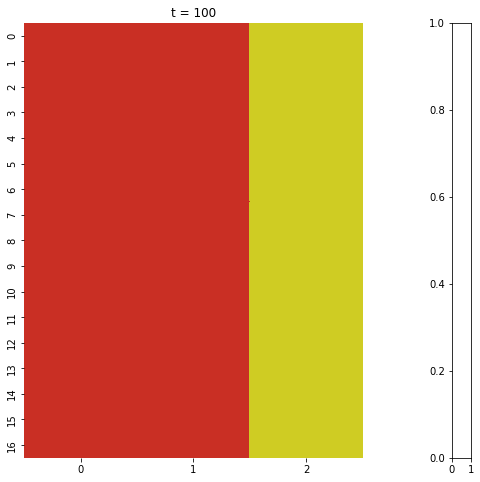

In [ ]:
generate_cf2_animation(grids,'2day.mp4')

In [ ]:
import timeit
start = timeit.default_timer()
EMPTY = 0
BURNING = 2
DOUBLE = 3
TREE = 1

def initForest(n,probTree):
  forest = np.zeros((n + 2,n + 2))
  return applyTrees(forest,probTree)

def applyTrees(bar,probTree):
  newBar = bar.copy()
  n = bar.shape[0] - 2
  for i in range(1,n + 1):
    for j in range(1,n + 1):
      x = np.random.uniform(0,1)
      if x < probTree:
        newBar[i][j] = TREE
      else:
        newBar[i][j] = EMPTY
  return newBar

def diffusion(site,N,E,S,W,adjBurn,wind,fire_direc):
  if site == EMPTY:
    return EMPTY
  elif site == DOUBLE:
    return EMPTY
  elif site == BURNING:
    return DOUBLE
  else:
    x = np.random.uniform(0,1)
    adjBurn = adjBurn + 0.25*wind
    # print(adjBurn)
    if fire_direc == 'N':
      if S < 2:
        adjBurn = adjBurn - 0.3 - 0.2*wind
    if fire_direc == 'S':
      if N < 2:
        adjBurn = adjBurn - 0.3 - 0.2*wind
    if fire_direc == 'E':
      if W < 2:
        adjBurn = adjBurn - 0.3 - 0.2*wind
    if fire_direc == 'W':
      if E < 2:
        adjBurn = adjBurn - 0.3 - 0.2*wind
    # print(adjBurn)
    if N > 1 or S > 1 or W > 1 or E > 1:
      if x < adjBurn:
        return BURNING
      else:
        return TREE
    else:
      return TREE
    
def whole_diff(n,bar,adjBurn,wind,fire_direc):
  new_bar = bar.copy()
  for i in range(1,n+1):
    for j in range(1,n+1):
      x = diffusion(bar[i][j],bar[i-1][j],bar[i][j + 1],bar[i + 1][j],bar[i][j-1],adjBurn,wind,fire_direc)
      new_bar[i][j] = x  
  return new_bar

def periodic(n,bar):
  new_bar = bar.copy()
  for i in range(1,n + 1):
    new_bar[0][i] = bar[n][i]
    new_bar[n+1][i] = bar[1][i]
  for i in range(0,n+2):
    new_bar[i][0] = new_bar[i][n]
    new_bar[i][n + 1] = new_bar[i][1]
  
  return new_bar

def algorithm(n,probTree,adjBurn,method,wind,fire_direc):
  bar = initForest(n,probTree)
  trees = 0
  null = 0
  for i in range(1, n+1):
    for j in range(1 , n+1):
      if bar[i][j] == TREE:
        trees = trees + 1
      elif bar[i][j] == EMPTY:
        null = null + 1
  num_itr = 50
  for i in range(n//2 - 1,n//2 + 1):
    for j in range(n//2 - 1,n//2 + 1):
      bar[i][j] = BURNING
  nbar = bar.copy()
  nbar = np.delete(nbar,(0,n+1),axis=0)
  nbar = np.delete(nbar,(0,n+1),axis=1)
  grid_list = []
  grid_list.append(nbar)
  for i in range(num_itr):
    bar = whole_diff(n,bar,adjBurn,wind,fire_direc)
    nbar = bar
    nbar = periodic(n,nbar)
    nbar = np.delete(nbar,(0,n+1),axis=0)
    nbar = np.delete(nbar,(0,n+1),axis=1)
    grid_list.append(nbar)


  return grid_list,trees,null


m = 30
n = 50
probTree = 0.8
adjBurn = 0.6
wind = 2
fire_direc = 'N'
grid_list = algorithm(n,probTree,adjBurn,3,wind,fire_direc)

# fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize=(6, 6))
# ax.set_facecolor('grey')
generate_animation(grid_list,'N_high.mp4')

AttributeError: ignored

#Code - 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplt
import math as m
from tqdm import tqdm
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

zero_color = "#cfcc23"
one_color = "#208724"
two_color = "#c92f24"
grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.2}
colors = [zero_color, one_color, two_color]
c_map = matplt.colors.LinearSegmentedColormap.from_list("", colors)

In [ ]:
EMPTY = 0
TREE = 1
BURNING = 2

In [ ]:
def init_forest(n, prob_tree, prob_burning):
    grid = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if(np.random.uniform(0,1) < prob_tree):
                if(np.random.uniform(0,1) < prob_burning):
                    grid[i][j] = BURNING
                else:
                    grid[i][j] = TREE
            else:
                grid[i][j] = EMPTY
    return grid

In [ ]:
def reflecting_lat(lat):
    lat_NS = np.row_stack((lat[0], lat, lat[-1]))
    return np.column_stack((lat_NS[:,0], lat_NS, lat_NS[:,-1]))

In [ ]:
def periodic_lat(lat):
    lat_NS = np.row_stack((lat[-1], lat, lat[0]))
    return np.column_stack((lat_NS[:,-1], lat_NS, lat_NS[:,0]))   

In [ ]:
def spread(site, N, E, S, W, prob_light, prob_immune):
    if(site == EMPTY or site == BURNING):
        return EMPTY
    else:
        if(N==BURNING or E==BURNING or S==BURNING or W==BURNING):
            if(np.random.uniform(0,1) < prob_immune):
                return TREE
            else:
                return BURNING
        else:
            if(np.random.uniform(0,1) < prob_light * (1 - prob_immune)):
                return BURNING
            else:
                return TREE

In [ ]:
def apply_extended(grid, prob_light, prob_immune):
    n = grid.shape[0] - 2
    new_grid = np.zeros((n,n))
    for i in range(1, n+1):
        for j in range(1, n+1):
            site = grid[i][j]
            N = grid[i-1][j]
            E = grid[i][j+1]
            S = grid[i+1][j]
            W = grid[i][j-1]
            new_grid[i-1][j-1] = spread(site, N, E, S, W, prob_light, prob_immune)
    return new_grid

In [ ]:
def fire(n, prob_tree, prob_burning, prob_light, prob_immune, t):
    forest = init_forest(n, prob_tree, prob_burning)
    grids = np.zeros((t+1, n, n))
    grids[0,:,:] = forest
    for i in range(1, t+1):
        forest_ext = periodic_lat(forest)
        forest = apply_extended(forest_ext, prob_light, prob_immune)
        grids[i,:,:] = forest
    return grids

In [ ]:
color_map = {0: np.array([255, 255, 0]), # yellow
             1: np.array([0, 180, 0]), # green
             2: np.array([255, 0, 0])} # orange 

In [ ]:
def colour_forest(data):
    data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 3), dtype=int)
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            data_3d[i][j] = color_map[data[i][j]]
    return data_3d

In [ ]:
def generate_animation(grids, filename):
    t = grids.shape[0]
    fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize=(8, 8))

    def render_frame(i):
        g = sns.heatmap(grids[i],
            ax = ax,
            cbar_ax = cbar_ax,
            cbar = False,
            # annot = labels,
            vmin = 0,
            vmax = 2,
            cmap=c_map)
        ax.set_title('t = ' + str(i))
        # g.cax.set_visible(False)

    anim = FuncAnimation(fig = fig, func = render_frame, frames=tqdm(np.arange(len(grids)), initial=1), interval = 1000.0/5, blit = False, repeat = False)

    anim.save(filename, writer = 'ffmpeg', fps = 5)

In [ ]:
np.random.seed(2)
n = 50
prob_tree = 0.9
prob_burning = 0.001
prob_light = 0.0
prob_immune = 0.0
t = 60
grids = fire(n, prob_tree, prob_burning, prob_light, prob_immune, t)

  2%|▏         | 1/61 [00:00<?, ?it/s]


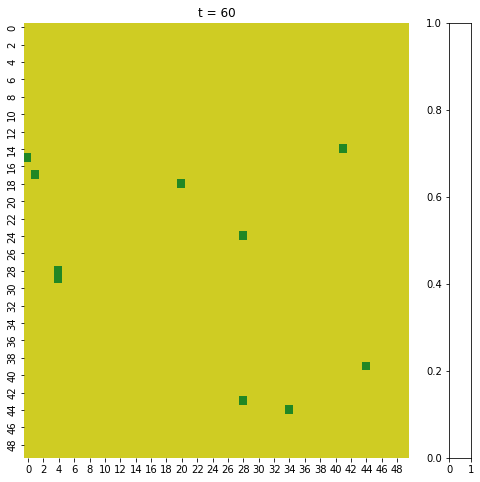

In [ ]:
generate_animation(grids,'1.mp4')

#Code - 3

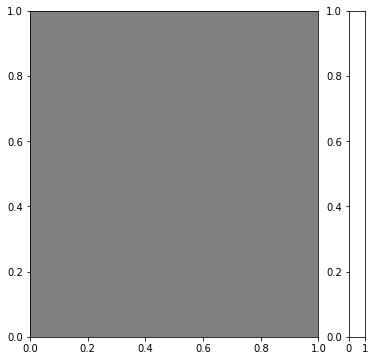

In [ ]:
from numpy import random

EMPTY = 0
BURNING = 2
TREE = 1
def applyTrees(bar,probTree,probBurning):
  newBar = bar.copy()
  n = bar.shape[0] - 2
  for i in range(1,n + 1):
    for j in range(1,n + 1):
      x = random.uniform(0,1)
      if x < probTree:
        y = random.uniform(0,1)
        if y < probBurning:
          newBar[i][j] = BURNING
        else:
          newBar[i][j] = TREE
      else:
        newBar[i][j] = EMPTY
  return newBar

def initForest(n,probTree,probBurning):
  forest = np.zeros((n + 2,n + 2))
  return applyTrees(forest,probTree,probBurning)


def diffusion(site,N,E,S,W,probImmune,probLightening):
  if site == EMPTY:
    return EMPTY
  elif site == BURNING:
    return EMPTY
  else:
    x = random.uniform(0,1)
    if x < probImmune:
      return TREE
    else:
      if N == BURNING or E == BURNING or S == BURNING or W == BURNING:
        return BURNING
      else:
        y = random.uniform(0,1)
        if y < probLightening:
          return BURNING
        else:
          return TREE

def whole_diff(n,bar,probImmune,probLightening):
  new_bar = bar.copy()
  for i in range(1,n+1):
    for j in range(1,n+1):
      x = diffusion(bar[i][j],bar[i-1][j],bar[i][j + 1],bar[i + 1][j],bar[i][j-1],probImmune,probLightening)
      new_bar[i][j] = x  
  return new_bar

def periodic(n,bar):
  new_bar = bar.copy()
  for i in range(1,n + 1):
    new_bar[0][i] = bar[n][i]
    new_bar[n+1][i] = bar[1][i]
  for i in range(0,n+2):
    new_bar[i][0] = new_bar[i][n]
    new_bar[i][n + 1] = new_bar[i][1]
  
  return new_bar

def algorithm(n,probTree,probBurning,probImmune,probLightening):
  bar = initForest(n,probTree,probBurning)
  num_itr = 50
  nbar = bar.copy()
  nbar[40][28] = 2
  nbar = np.delete(nbar,(0,n+1),axis=0)
  nbar = np.delete(nbar,(0,n+1),axis=1)
  grid_list = []
  grid_list.append(nbar)
  for i in range(num_itr):
    bar = whole_diff(n,bar,probImmune,probLightening)
    nbar = bar
    nbar = periodic(n,nbar)
    nbar = np.delete(nbar,(0,n+1),axis=0)
    nbar = np.delete(nbar,(0,n+1),axis=1)
    grid_list.append(nbar)
  return grid_list

# m = 30
# n = 50
# probTree = 0.8
# probBurning = 0.0005
# probImmune = 0.25
# probLightening = 0.00001

#np.random.seed(2)
n = 50
prob_tree = 0.8
prob_burning = 0.0005
probLightening = 0.00001
prob_immune = 0.25
# grids = fire(n, prob_tree, prob_burning, prob_light, prob_immune, t)
grid_list = algorithm(n,probTree,probBurning,probImmune,probLightening)

fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize=(6, 6))
ax.set_facecolor('grey')

In [ ]:
# render and play animation
anim = FuncAnimation(fig = fig, func = render_frame, frames=tqdm(range(len(grid_list)), initial=1, position=0), fargs=(grid_list,), interval = 1000.0/fps, blit = False, repeat = False)
anim

  2%|▏         | 1/51 [00:00<?, ?it/s]


In [ ]:
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
# function to render frames for animations
from tqdm import tqdm
from matplotlib import rc
rc('animation', html='jshtml')

fps = 8.0
dt = 1
grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.2}

def render_frame(i, data):
    ax.cla()

    grid = data[i].tolist()
    # print(data)
    rows = len(grid)
    cols = len(grid[0])
    labels = []
    for r in range(rows):
      temp = []
      for c in range(cols):
        temp.append(grid[r][c])
      labels.append(temp)
    myColors = ((1.0, 1.0, 1.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    sns.heatmap(data[i],
                ax = ax,
                cbar = True,
                cbar_ax = cbar_ax,
                vmin = 0,
                vmax = 2,
                xticklabels=False,
                yticklabels = False,
                cmap=cmap,
                cbar_kws={'label': 'Temperature'})